In [1]:
import torch
from tile_types import TileType
from world import World
from agent import Agent
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
from spiking_feast import SpikingFEAST

lr = 0.1
num_epochs = 100
num_steps_per_epoch = 500
#num_ticks_per_step = 50
reward = 0
action = 0
p_random_action_initial = 1.0
p_random_action_decay = 0.99 # 1 means no decay

world: World = World()
agent: Agent = Agent()
duration_history = []

#weights_1_history = torch.zeros((num_epochs, agent.input_size, agent.hidden_size))
net = SpikingFEAST(agent.input_size, agent.hidden_size, agent.output_size, lr=5)

def simulate_epoch() -> int:
    step: int = 0
    reward: float = 0.0
    p_random_action: float = p_random_action_initial
    
    #weights_1_history[step] = agent.model.input_layer.weights # type: ignore
    
    for step in range(num_steps_per_epoch):
        
        # Decay the learning parameters
        p_random_action *= p_random_action_decay
        
        # Generate the visual input
        agent.update_visual_field(world)
        
        # Compute the action from the feed-forward neural network
        #agent.select_action(reward, p_random_action, learning=True)
        activation = net(agent.visual_field, reward=0)
        action_index = torch.argmin(activation)
        action = agent.actions[action_index]
        
        # Take the action and get the reward
        if torch.rand(1) < p_random_action:
            action = 'random'
        reward = agent.step(action, world)

        # Learning
        net(agent.visual_field, reward=reward)
        
        # Exit early if the agent is done
        if world.is_complete():
            break
    return step

# Training loop
for _ in tqdm(range(num_epochs), desc='Epoch', leave=True):
    # Initialize the session 
    world.reset()

    sim_duration = simulate_epoch()
        
    # Update the performance history
    duration_history.append(sim_duration)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

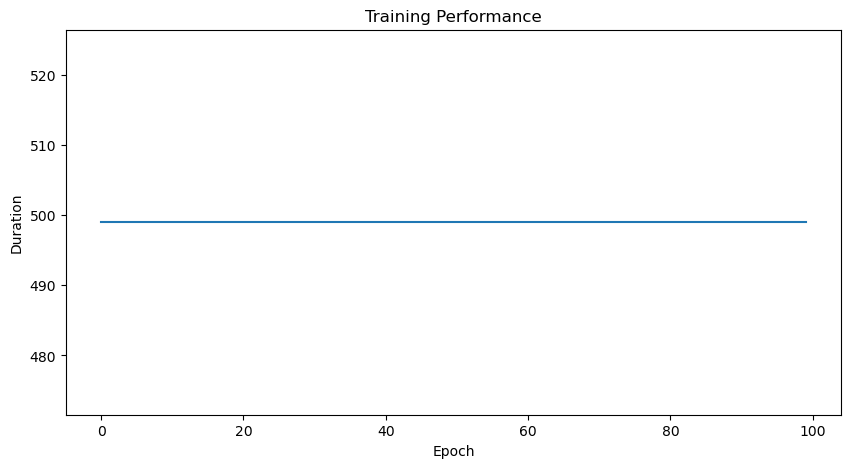

In [2]:
fig = plt.figure(figsize=(10, 5))
plt.plot(duration_history)
plt.ylabel('Duration')
plt.xlabel('Epoch')
plt.title('Training Performance');